<a href="https://colab.research.google.com/github/armandordorica/Twitter_Sentiment_Analysis/blob/master/Covid19_NYC_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Covid 19 Cases**

The goal of this project is to analyze the evolution of Covid-19 cases in New York City. Particularly, we'd like to know if it's possible to improve univariate time series predictions by leveraging sentiment analysis on tweets related to Covid-19 in New York City area as well. 



The source data is coming from the World Health Organization and is updated daily. 

In [0]:
import pandas as pd
from pandas import read_csv
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
series = read_csv(url, header=0)


**Cleaning the data to keep New York data only**

In [412]:
series[series['Combined_Key'].str.match('New York')]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572


In [0]:
df = pd.DataFrame(series)
df_ny = df.iloc[1863]
df_ny = pd.DataFrame(df_ny)
df_ny = df_ny.T

cols = list(df_ny.columns)
df_ny = df_ny[cols[10:]]

In [414]:
df_ny

,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
1863,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572


In [0]:
list_of_dates= list(df_ny.columns)
list_of_dates = list_of_dates[40:]

list(df_ny.values)
values = list(df_ny.iloc[0])[40:]

In [416]:
data = {'Date':list_of_dates, 'Num of daily cases': values} 
df = pd.DataFrame(data)
df.head(20)

,Date,Num of daily cases
0,3/1/20,0
1,3/2/20,1
2,3/3/20,1
3,3/4/20,1
4,3/5/20,4
5,3/6/20,11
6,3/7/20,11
7,3/8/20,12
8,3/9/20,19
9,3/10/20,25


In [0]:
dates = list(df['Date'])
dates = pd.date_range(start=str(dates[0]),end=str(dates[-1]))
dates = list(dates)


list_of_dates =  []
for i in range(0, len(dates)):
  list_of_dates.append(dates[i].strftime("%b-%d"))

x_ticks= [list_of_dates[i] for i in range(0, len(list_of_dates), 5)]

([<matplotlib.axis.XTick at 0x7f0dd6559c88>,
 <a list of 10 Text major ticklabel objects>)

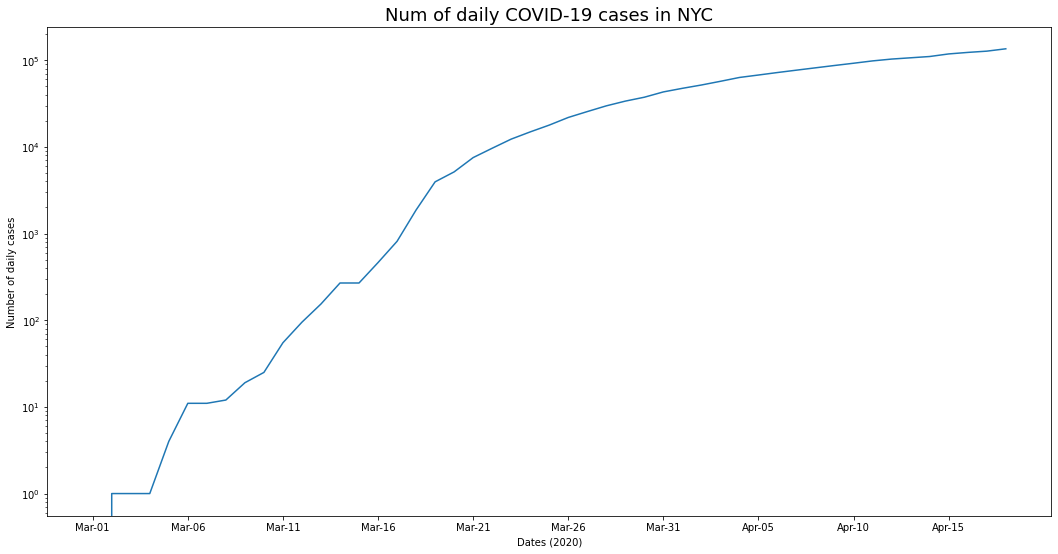

In [478]:
from matplotlib import pyplot as plt

plt.figure(figsize = (18,9))
plt.yscale("log")

plt.title("Num of daily COVID-19 cases in NYC", fontsize = 18)
plt.plot(list_of_dates, df['Num of daily cases'])
plt.ylabel("Number of daily cases")
plt.xlabel("Dates (2020)")
plt.xticks(x_ticks)

### Setting up our baseline model

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

For the purpose of this analysis, I have chosen `order=(3,0,0)`.

In [0]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [421]:
series = df['Num of daily cases']
series.index = df['Date']
series.shape

(49,)

### Now we'll split dataset in training and validation. 

In [422]:
validation_size =round(len(series)*.2)
split_point = len(series) -validation_size 

print("The size of our validation set is: {}, which corresponds to 20% of our examples.".format(validation_size))

dataset, validation = series[0:split_point], series[split_point:]

print("The training set goes from {} to {} and the validation set goes from {} to {}".format(dataset.index[0], dataset.index[-1], validation.index[0], validation.index[-1] ))

The size of our validation set is: 10, which corresponds to 20% of our examples.
The training set goes from 3/1/20 to 4/8/20 and the validation set goes from 4/9/20 to 4/18/20


In [423]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# load dataset
# seasonal difference
X = dataset.values
days_in_year = 1
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,0))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   38
Model:                     ARMA(7, 0)   Log Likelihood                -293.533
Method:                       css-mle   S.D. of innovations            515.376
Date:                Sun, 19 Apr 2020   AIC                            605.066
Time:                        23:50:45   BIC                            619.804
Sample:                             0   HQIC                           610.310
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1935.4679    879.539      2.201      0.036     211.602    3659.334
ar.L1.y        0.3081      0.161      1.919      0.065      -0.007       0.623
ar.L2.y        0.3697      0.156      2.371      0.0

In [424]:
len(dataset)

39

In [425]:
len(validation)

10

In [0]:
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)

In [427]:
from pandas import datetime
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)
print('Forecast: %f' % forecast)

Forecast: 85771.094729


In [0]:
# multi-step out-of-sample forecast
num_steps = 10
forecast = model_fit.forecast(steps=num_steps)[0]

In [429]:
forecast_one_week_ahead = []
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 85771.094729
Day 2: 89495.019766
Day 3: 93407.251220
Day 4: 97067.539606
Day 5: 100134.304754
Day 6: 102955.519937
Day 7: 105747.126035
Day 8: 108271.406274
Day 9: 110369.656892
Day 10: 112261.517852


In [0]:
pd.DataFrame(history).to_csv("history.csv")

In [431]:
validation[:num_steps]

Date
4/9/20      87028
4/10/20     92384
4/11/20     98308
4/12/20    103208
4/13/20    106763
4/14/20    110465
4/15/20    118302
4/16/20    123146
4/17/20    127352
4/18/20    135572
Name: Num of daily cases, dtype: int64

In [432]:
print("For the next {} days, from {} the values forecasted are: {}. \nThe true values are:{} ".format(num_steps, dataset.index[-1], history[-num_steps:], validation[:num_steps]))

For the next 10 days, from 4/8/20 the values forecasted are: [85771.09472933489, 89495.01976560151, 93407.25122042082, 97067.53960558794, 100134.3047537031, 102955.51993689436, 105747.12603464875, 108271.40627377042, 110369.65689195148, 112261.51785234839]. 
The true values are:Date
4/9/20      87028
4/10/20     92384
4/11/20     98308
4/12/20    103208
4/13/20    106763
4/14/20    110465
4/15/20    118302
4/16/20    123146
4/17/20    127352
4/18/20    135572
Name: Num of daily cases, dtype: int64 


In [0]:
import numpy as np
history_np = np.array(history)

Text(0.5, 1.0, 'Num of daily COVID-19 cases in NYC')

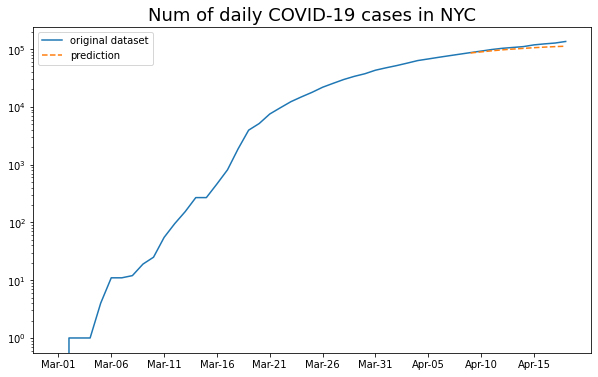

In [473]:
plt.figure(figsize = (10,6))

plt.yscale("log")
plt.plot(list_of_dates, list(series)[-50:], label = 'original dataset' )
plt.plot(list_of_dates[-10:], history[-10:], label = 'prediction' , ls = 'dashed')
plt.xticks(x_ticks)
plt.legend()

plt.title("Num of daily COVID-19 cases in NYC", fontsize = 18)


In [0]:
true_values = list(series)[-10:]

In [0]:
predicted_values = list(history[-10:])

In [0]:
data = {'true_values': true_values, 
        'predicted_values': predicted_values}
comparison = pd.DataFrame(data)

In [453]:
log_comparison = np.log10(comparison)
log_comparison


,true_values,predicted_values
0,4.939659,4.933341
1,4.965597,4.951799
2,4.992589,4.970381
3,5.013713,4.987074
4,5.028421,5.000583
5,5.043225,5.012650
6,5.072992,5.024269
7,5.090420,5.034514
8,5.105006,5.042850
9,5.132170,5.050231


In [0]:
log_comparison['error']= (log_comparison['true_values'] - log_comparison['predicted_values'])/log_comparison['true_values']

On the plot below we can see that the prediction error is very low even for far ahead values. 

Forecasting using ARIMA can be thought of as a random process modeled as a random walk, where variance increases with time. Since the error depends on the variance, it also increases linearly (parabolically) with time.

The ARIMA model was trained on only 39 examples and it has been able to predict 10 days ahead with less than 2% error.   

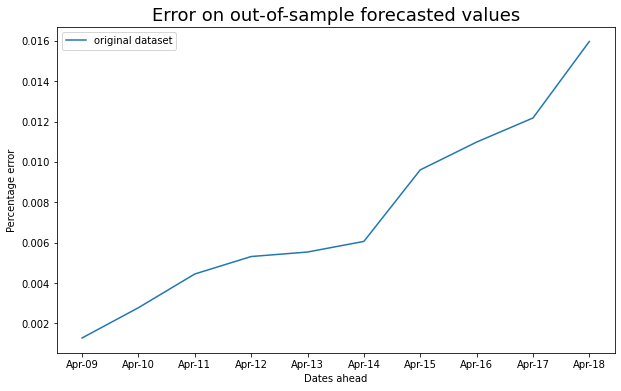

In [480]:
log_comparison['error']

plt.figure(figsize = (10,6))

plt.plot(list_of_dates[-10:], log_comparison['error'], label = 'original dataset' )
plt.title("Error on out-of-sample forecasted values", fontsize = 18)
plt.ylabel("Percentage error")
plt.xlabel("Dates ahead")

plt.legend()


### **Twitter Sentiment Analysis**
The following section performs sentiment analysis on Twitter data

In [492]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
series = read_csv(url, header=0)
series[series['Combined_Key'].str.match('New York')]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572,138700


In [0]:
df = pd.DataFrame(series)
df_ny = df.iloc[1863]
df_ny = pd.DataFrame(df_ny)
df_ny = df_ny.T

In [494]:
df_ny

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
1863,84036061,US,USA,840,36061,New York,New York,US,40.7673,-73.9715,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572,138700


In [496]:
cols = list(df_ny.columns)
df_ny = df_ny[cols[10:]]
df_ny = df_ny[['Combined_Key','3/4/20',
       '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20',
       '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20',
       '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20',
       '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20']]
df_ny = df_ny.T
df_ny.head()

,1863
Combined_Key,"New York City, New York, US"
3/4/20,1
3/5/20,4
3/6/20,11
3/7/20,11
3/8/20,12
3/9/20,19
3/10/20,25
3/11/20,55
3/12/20,95


In [497]:
import datetime
base = datetime.datetime(2020, 3, 28)
date_list = [base - datetime.timedelta(days=x) for x in range(25)]

list_of_dates =  []
for i in range(0, len(date_list)):
  list_of_dates.append(date_list[i].strftime("%Y-%m-%d"))

list_of_dates.reverse()
list_of_dates

['2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28']

In [0]:
list_of_lists = df_ny.iloc[1:].values
flattened_values  = [val for sublist in list_of_lists for val in sublist]

In [499]:
len(flattened_values)

25

In [500]:
len(list_of_dates)

25

In [0]:
d = {'date': list_of_dates, 'Num of Cases in NY': flattened_values}

In [0]:
df = pd.DataFrame(data=d)

### Getting the Twitter data

In [505]:
url = "https://raw.githubusercontent.com/armandordorica/Twitter_Sentiment_Analysis/master/raw_data/ny_covid_twitter_data.csv"
from pandas import read_csv
twitter_df = read_csv(url, header=0)
twitter_df.head()

,Unnamed: 0,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at
0,48,2020-03-04T11:22:46Z,Can &amp; focus on tackling potential Corona...,Twitter for iPhone,False,False,25462.0,0.0,"Queens, NY",city,12378.0,13567.0,2009-01-21T21:17:54Z
1,1111,2020-03-04T13:46:00Z,(3/3) \n🧳 Self-evaluation of inherent bias/rac...,Twitter for iPhone,False,False,6366.0,0.0,"Manhattan, NY",city,656.0,829.0,2017-12-03T21:45:57Z
2,1701,2020-03-04T14:39:30Z,Sensible feedback on the CoronavirusOutbreak,Twitter for iPhone,True,False,1623.0,0.0,"Manhattan, NY",city,248.0,1309.0,2018-02-06T22:46:58Z
3,1737,2020-03-04T14:41:57Z,Bill Gates tried to warn us 4 years ago about ...,Twitter for Android,False,False,39912.0,0.0,"Brooklyn, NY",city,1511.0,2619.0,2009-06-19T20:33:46Z
4,2344,2020-03-04T15:44:59Z,👀😁CoronavirusOutbreak,Twitter for iPhone,False,False,41637.0,0.0,"New York, NY",admin,358.0,563.0,2019-05-08T11:02:45Z


In [0]:
df_ny = twitter_df

In [0]:
from textblob import TextBlob

# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [515]:
getSubjectivity(df_ny['text'][0])

0.65

In [517]:
df_ny.dropna(subset=['text'])

,Unnamed: 0,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at
0,48,2020-03-04T11:22:46Z,Can &amp; focus on tackling potential Corona...,Twitter for iPhone,False,False,25462.0,0.0,"Queens, NY",city,12378.0,13567.0,2009-01-21T21:17:54Z
1,1111,2020-03-04T13:46:00Z,(3/3) \n🧳 Self-evaluation of inherent bias/rac...,Twitter for iPhone,False,False,6366.0,0.0,"Manhattan, NY",city,656.0,829.0,2017-12-03T21:45:57Z
2,1701,2020-03-04T14:39:30Z,Sensible feedback on the CoronavirusOutbreak,Twitter for iPhone,True,False,1623.0,0.0,"Manhattan, NY",city,248.0,1309.0,2018-02-06T22:46:58Z
3,1737,2020-03-04T14:41:57Z,Bill Gates tried to warn us 4 years ago about ...,Twitter for Android,False,False,39912.0,0.0,"Brooklyn, NY",city,1511.0,2619.0,2009-06-19T20:33:46Z
4,2344,2020-03-04T15:44:59Z,👀😁CoronavirusOutbreak,Twitter for iPhone,False,False,41637.0,0.0,"New York, NY",admin,358.0,563.0,2019-05-08T11:02:45Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20687,15443927,2020-03-25T23:13:33Z,Takeout in the age of coronavirus:\n\nStep 1: ...,Twitter for iPhone,False,False,20.0,0.0,"New York, NY",admin,3.0,11.0,2020-03-07T05:35:22Z
20688,15447672,2020-03-25T23:22:18Z,JOIN US LIVE: We might be isolated and SocialD...,Twitter for Android,False,False,850.0,2.0,"New York, NY",admin,1243.0,954.0,2008-12-12T16:25:35Z
20689,15453231,2020-03-25T23:34:43Z,COVID19,Twitter for iPhone,False,False,17646.0,0.0,"New York, USA",admin,1312.0,2165.0,2008-10-27T19:40:19Z
20690,15453397,2020-03-25T23:35:05Z,"Missing the Broadcast Center, missing the tea...",Twitter for Android,False,False,294926.0,0.0,"New York, NY",admin,1394.0,1369.0,2010-09-12T17:17:03Z


In [518]:
df_ny['Subjectivity'] = df_ny['text'].apply(getSubjectivity)
# df_ny['Polarity'] = df_ny['text'].apply(getPolarity)


TypeError: ignored